# 04 - EDA: Player Progression

**Purpose**: Understand trophy progression patterns and player skill development.

**Key Questions**:
- Where do players hit trophy "walls"?
- How do deck characteristics change with trophy level?
- Is there trophy inflation/deflation?
- What separates winners from losers at different skill levels?

**Potential Insights**:
- Identify key trophy milestones (4000, 5000, 6000)
- Show how successful decks evolve with skill
- Analyze trophy risk at different levels

In [1]:
import sys, os, duckdb, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

# Use Parquet if available (faster), fallback to CSV
DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.parquet')
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.csv')

from duckdb_utils import get_connection, create_battles_view, query_to_df
from visualization import setup_presentation_style, plot_distribution, save_figure
from feature_engineering import create_trophy_bracket_features

con = get_connection()
create_battles_view(con, DATA_PATH)
setup_presentation_style()

✓ Created view 'battles' from Parquet: C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\battles.parquet
✓ Presentation style configured


## 1. Trophy Distribution

Visualize where players cluster

Executing query...


✓ Returned 33,591,916 rows, 1 columns


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig_trophy_distribution.png


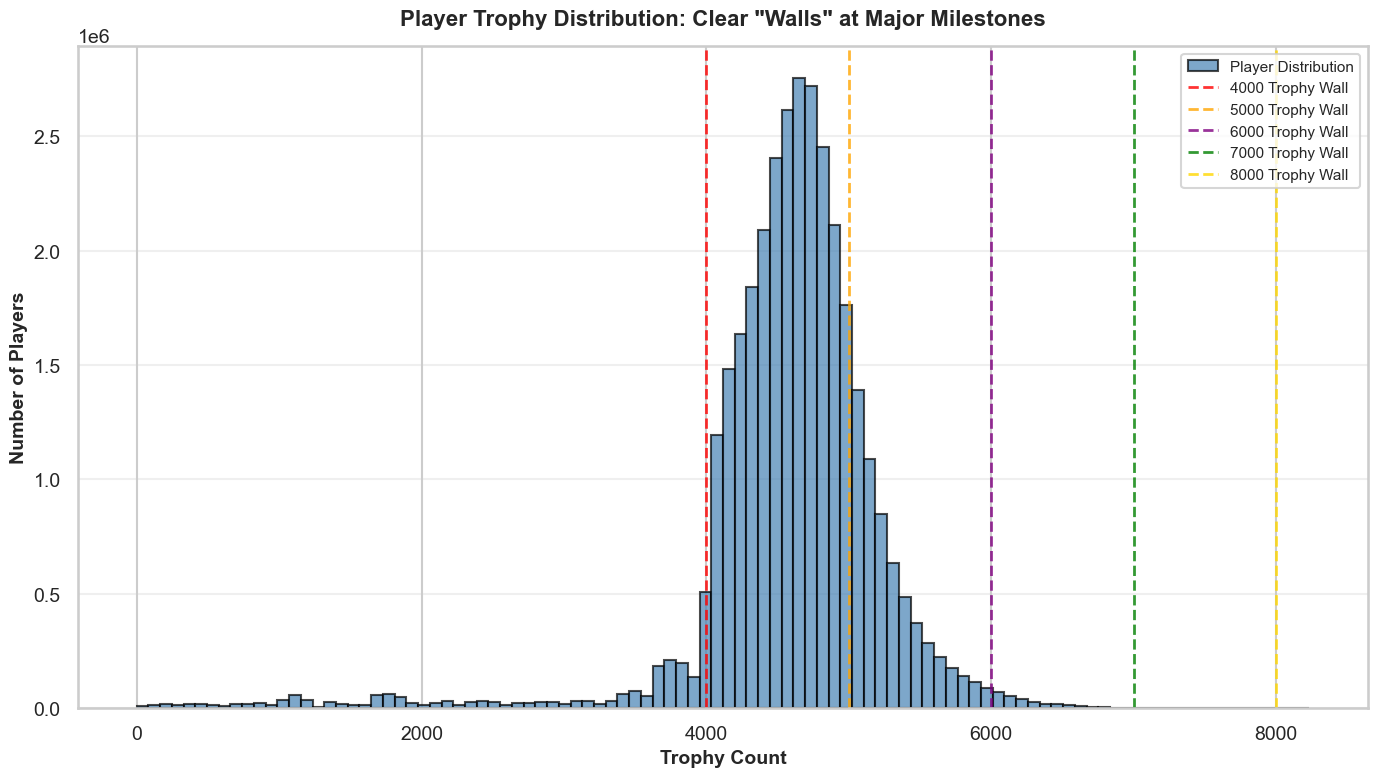

✓ Analyzed 33,591,916 player trophy counts

Trophy range statistics:
  Min: 0.0
  Max: 8,233.0


  Mean: 4,596


  Median: 4,644


In [2]:
# Query trophy distribution data
trophy_dist_query = """
    SELECT 
        "winner.startingTrophies" as trophies
    FROM battles
    UNION ALL
    SELECT 
        "loser.startingTrophies" as trophies
    FROM battles
"""

trophy_data = query_to_df(con, trophy_dist_query)

# Create histogram with trophy walls highlighted
fig, ax = plt.subplots(figsize=(14, 8))

# Create histogram
ax.hist(trophy_data['trophies'], bins=100, color='steelblue', 
        edgecolor='black', alpha=0.7, label='Player Distribution')

# Highlight major trophy walls (milestones)
trophy_walls = [4000, 5000, 6000, 7000, 8000]
colors = ['red', 'orange', 'purple', 'green', 'gold']
for wall, color in zip(trophy_walls, colors):
    ax.axvline(wall, color=color, linestyle='--', linewidth=2, 
               label=f'{wall} Trophy Wall', alpha=0.8)

ax.set_xlabel('Trophy Count', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Players', fontsize=14, fontweight='bold')
ax.set_title('Player Trophy Distribution: Clear "Walls" at Major Milestones', 
             fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_figure('fig_trophy_distribution.png')
plt.show()

print(f"✓ Analyzed {len(trophy_data):,} player trophy counts")
print("\nTrophy range statistics:")
print(f"  Min: {trophy_data['trophies'].min():,}")
print(f"  Max: {trophy_data['trophies'].max():,}")
print(f"  Mean: {trophy_data['trophies'].mean():,.0f}")
print(f"  Median: {trophy_data['trophies'].median():,.0f}")

## 2. Trophy Change Analysis

Executing query...


✓ Returned 14 rows, 6 columns


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig_trophy_change_analysis.png


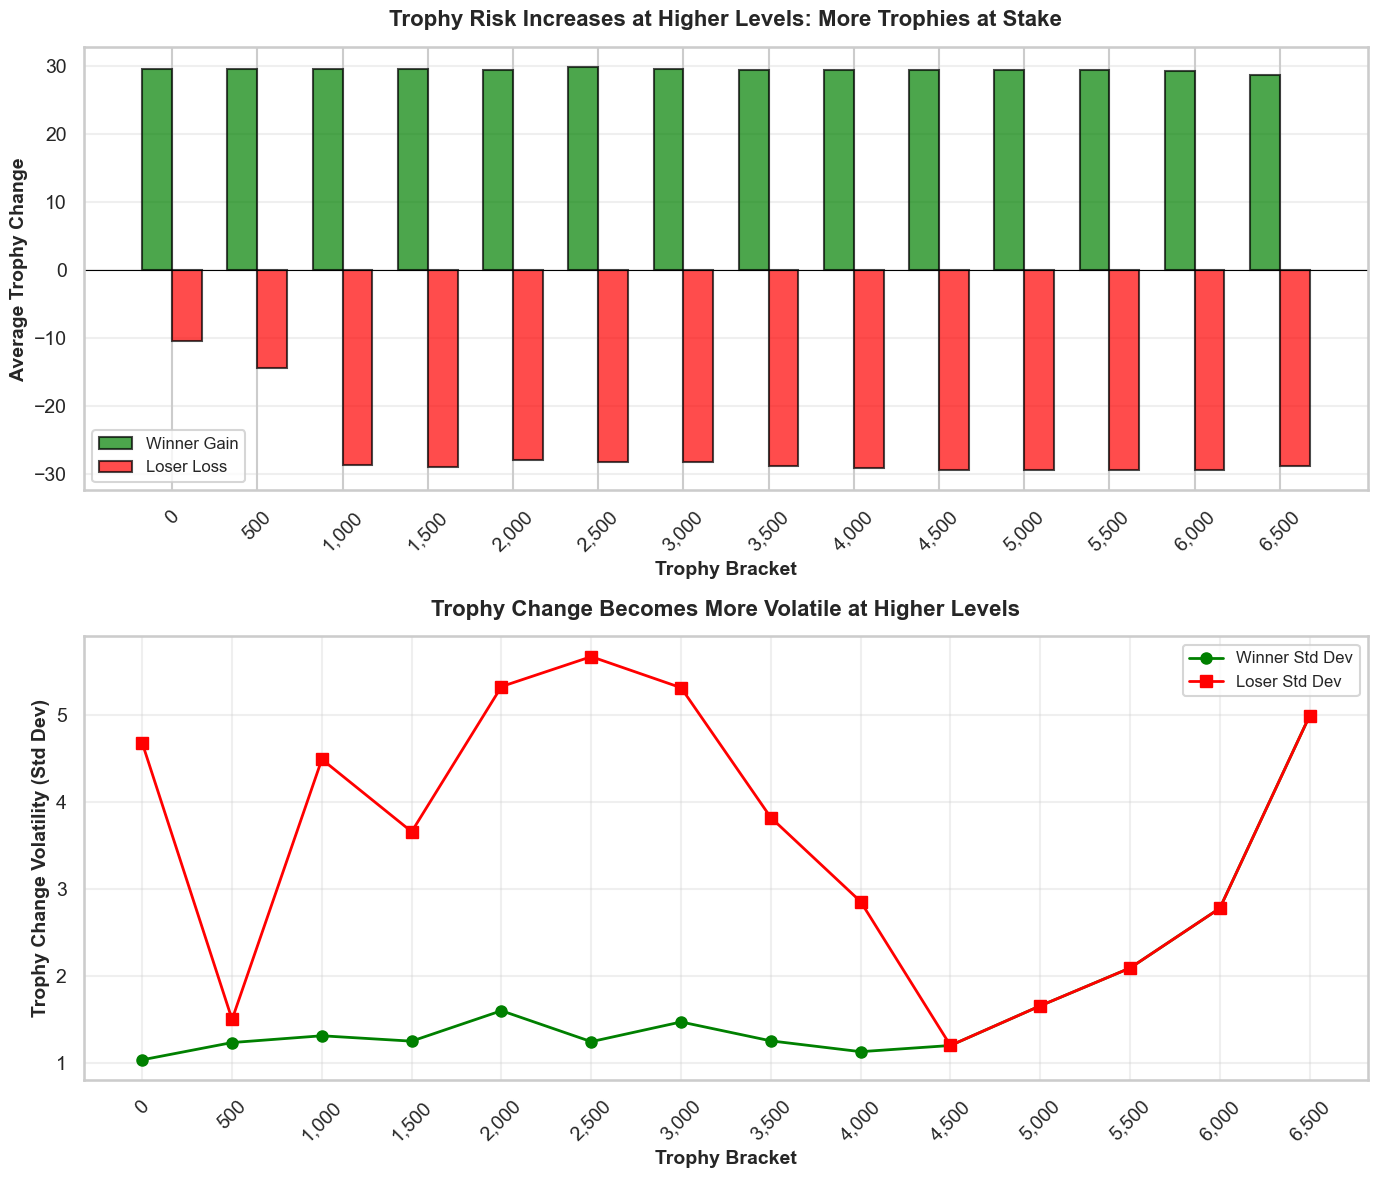

✓ Trophy change analysis complete

Key findings:
  Lowest bracket avg gain: 28.78
  Highest bracket avg gain: 29.88
  Lowest bracket avg loss: -10.44
  Highest bracket avg loss: -29.49


In [3]:
# Analyze trophy change patterns by starting trophy level
trophy_change_query = """
    SELECT 
        FLOOR("winner.startingTrophies" / 500) * 500 as trophy_bracket,
        AVG("winner.trophyChange") as avg_gain_winner,
        STDDEV("winner.trophyChange") as std_gain_winner,
        AVG("loser.trophyChange") as avg_loss_loser,
        STDDEV("loser.trophyChange") as std_loss_loser,
        COUNT(*) as battle_count
    FROM battles
    WHERE "winner.startingTrophies" IS NOT NULL 
      AND "loser.startingTrophies" IS NOT NULL
    GROUP BY trophy_bracket
    HAVING battle_count > 1000
    ORDER BY trophy_bracket
"""

trophy_change = query_to_df(con, trophy_change_query)

# Create visualization showing trophy gains/losses by bracket
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Average trophy change
ax = axes[0]
x_pos = np.arange(len(trophy_change))
width = 0.35

bars1 = ax.bar(x_pos - width/2, trophy_change['avg_gain_winner'], width, 
               label='Winner Gain', color='green', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x_pos + width/2, trophy_change['avg_loss_loser'], width, 
               label='Loser Loss', color='red', alpha=0.7, edgecolor='black')

ax.set_xlabel('Trophy Bracket', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Trophy Change', fontsize=14, fontweight='bold')
ax.set_title('Trophy Risk Increases at Higher Levels: More Trophies at Stake', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{int(t):,}" for t in trophy_change['trophy_bracket']], rotation=45)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Plot 2: Standard deviation (volatility)
ax = axes[1]
ax.plot(trophy_change['trophy_bracket'], trophy_change['std_gain_winner'], 
        marker='o', linewidth=2, markersize=8, label='Winner Std Dev', color='green')
ax.plot(trophy_change['trophy_bracket'], abs(trophy_change['std_loss_loser']), 
        marker='s', linewidth=2, markersize=8, label='Loser Std Dev', color='red')

ax.set_xlabel('Trophy Bracket', fontsize=14, fontweight='bold')
ax.set_ylabel('Trophy Change Volatility (Std Dev)', fontsize=14, fontweight='bold')
ax.set_title('Trophy Change Becomes More Volatile at Higher Levels', 
             fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# Format x-axis
ax.set_xticks(trophy_change['trophy_bracket'])
ax.set_xticklabels([f"{int(t):,}" for t in trophy_change['trophy_bracket']], rotation=45)

plt.tight_layout()
save_figure('fig_trophy_change_analysis.png')
plt.show()

print("✓ Trophy change analysis complete")
print("\nKey findings:")
print(f"  Lowest bracket avg gain: {trophy_change['avg_gain_winner'].min():.2f}")
print(f"  Highest bracket avg gain: {trophy_change['avg_gain_winner'].max():.2f}")
print(f"  Lowest bracket avg loss: {trophy_change['avg_loss_loser'].max():.2f}")
print(f"  Highest bracket avg loss: {trophy_change['avg_loss_loser'].min():.2f}")

## 3. Deck Evolution by Trophy Level

Executing query...


✓ Returned 14 rows, 10 columns


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig_deck_evolution.png


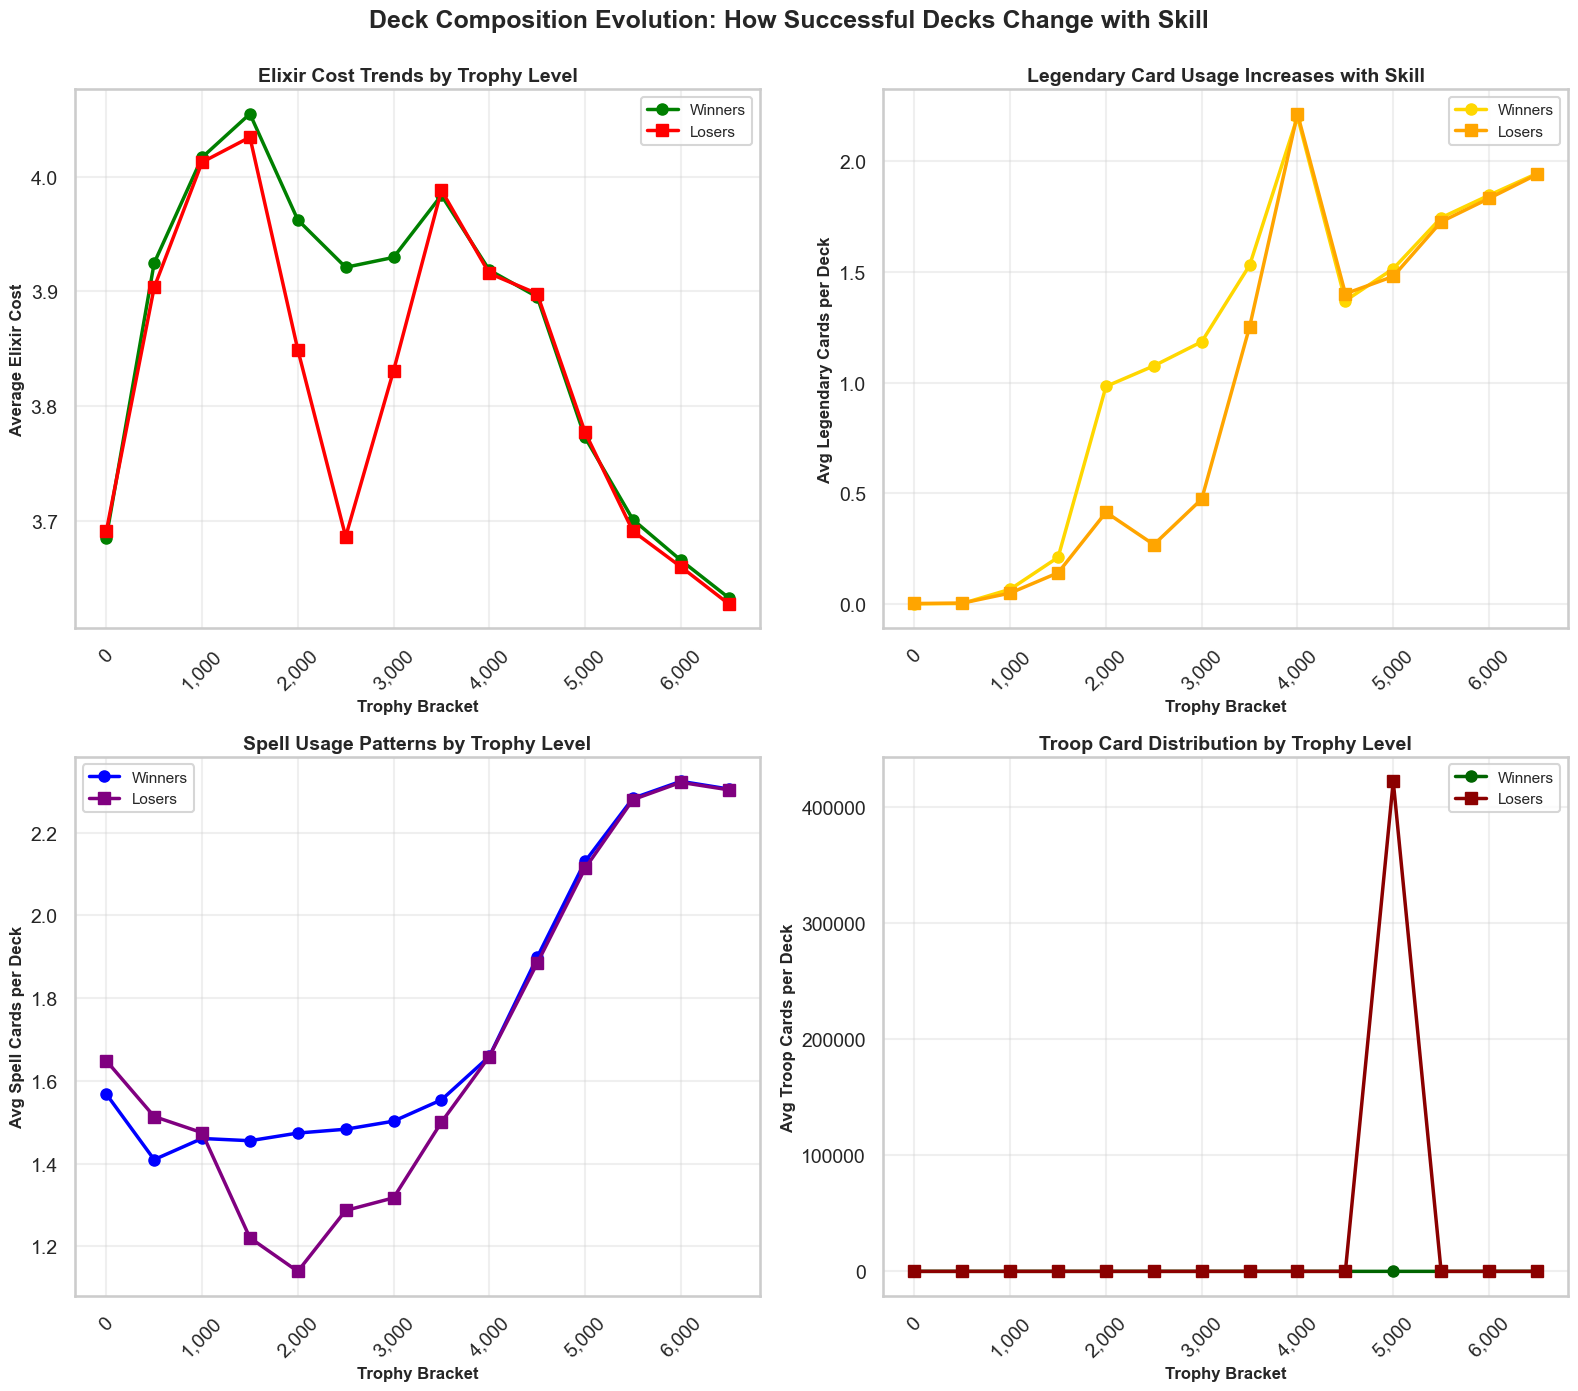

✓ Deck evolution analysis complete

Key insights:
  Winner elixir range: 3.63 - 4.05
  Winner legendary usage: 0.00 - 2.20
  Winner spell count: 1.41 - 2.32
  Winner troop count: 5.22 - 6.32


In [4]:
# Analyze how deck characteristics change with skill level
deck_evolution_query = """
    SELECT 
        FLOOR("winner.startingTrophies" / 500) * 500 as trophy_bracket,
        AVG("winner.elixir.average") as avg_elixir_winner,
        AVG("loser.elixir.average") as avg_elixir_loser,
        AVG("winner.legendary.count") as avg_legendary_winner,
        AVG("loser.legendary.count") as avg_legendary_loser,
        AVG(CAST("winner.spell.count" AS DOUBLE)) as avg_spell_winner,
        AVG(CAST("loser.spell.count" AS DOUBLE)) as avg_spell_loser,
        AVG(CAST("winner.troop.count" AS DOUBLE)) as avg_troop_winner,
        AVG(CAST("loser.troop.count" AS DOUBLE)) as avg_troop_loser,
        COUNT(*) as battle_count
    FROM battles
    WHERE "winner.startingTrophies" IS NOT NULL
    GROUP BY trophy_bracket
    HAVING battle_count > 1000
    ORDER BY trophy_bracket
"""

deck_evolution = query_to_df(con, deck_evolution_query)

# Create multi-panel visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Average Elixir Cost
ax = axes[0, 0]
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_elixir_winner'], 
        marker='o', linewidth=2.5, markersize=8, label='Winners', color='green')
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_elixir_loser'], 
        marker='s', linewidth=2.5, markersize=8, label='Losers', color='red')
ax.set_xlabel('Trophy Bracket', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Elixir Cost', fontsize=12, fontweight='bold')
ax.set_title('Elixir Cost Trends by Trophy Level', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xticks(deck_evolution['trophy_bracket'][::2])
ax.set_xticklabels([f"{int(t):,}" for t in deck_evolution['trophy_bracket'][::2]], rotation=45)

# Plot 2: Legendary Card Usage
ax = axes[0, 1]
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_legendary_winner'], 
        marker='o', linewidth=2.5, markersize=8, label='Winners', color='gold')
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_legendary_loser'], 
        marker='s', linewidth=2.5, markersize=8, label='Losers', color='orange')
ax.set_xlabel('Trophy Bracket', fontsize=12, fontweight='bold')
ax.set_ylabel('Avg Legendary Cards per Deck', fontsize=12, fontweight='bold')
ax.set_title('Legendary Card Usage Increases with Skill', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xticks(deck_evolution['trophy_bracket'][::2])
ax.set_xticklabels([f"{int(t):,}" for t in deck_evolution['trophy_bracket'][::2]], rotation=45)

# Plot 3: Spell Count
ax = axes[1, 0]
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_spell_winner'], 
        marker='o', linewidth=2.5, markersize=8, label='Winners', color='blue')
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_spell_loser'], 
        marker='s', linewidth=2.5, markersize=8, label='Losers', color='purple')
ax.set_xlabel('Trophy Bracket', fontsize=12, fontweight='bold')
ax.set_ylabel('Avg Spell Cards per Deck', fontsize=12, fontweight='bold')
ax.set_title('Spell Usage Patterns by Trophy Level', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xticks(deck_evolution['trophy_bracket'][::2])
ax.set_xticklabels([f"{int(t):,}" for t in deck_evolution['trophy_bracket'][::2]], rotation=45)

# Plot 4: Troop Count
ax = axes[1, 1]
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_troop_winner'], 
        marker='o', linewidth=2.5, markersize=8, label='Winners', color='darkgreen')
ax.plot(deck_evolution['trophy_bracket'], deck_evolution['avg_troop_loser'], 
        marker='s', linewidth=2.5, markersize=8, label='Losers', color='darkred')
ax.set_xlabel('Trophy Bracket', fontsize=12, fontweight='bold')
ax.set_ylabel('Avg Troop Cards per Deck', fontsize=12, fontweight='bold')
ax.set_title('Troop Card Distribution by Trophy Level', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xticks(deck_evolution['trophy_bracket'][::2])
ax.set_xticklabels([f"{int(t):,}" for t in deck_evolution['trophy_bracket'][::2]], rotation=45)

plt.suptitle('Deck Composition Evolution: How Successful Decks Change with Skill', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
save_figure('fig_deck_evolution.png')
plt.show()

print("✓ Deck evolution analysis complete")
print("\nKey insights:")
print(f"  Winner elixir range: {deck_evolution['avg_elixir_winner'].min():.2f} - {deck_evolution['avg_elixir_winner'].max():.2f}")
print(f"  Winner legendary usage: {deck_evolution['avg_legendary_winner'].min():.2f} - {deck_evolution['avg_legendary_winner'].max():.2f}")
print(f"  Winner spell count: {deck_evolution['avg_spell_winner'].min():.2f} - {deck_evolution['avg_spell_winner'].max():.2f}")
print(f"  Winner troop count: {deck_evolution['avg_troop_winner'].min():.2f} - {deck_evolution['avg_troop_winner'].max():.2f}")

## 4. Matchup Fairness

Executing query...
✓ Returned 500,000 rows, 4 columns


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig_matchup_fairness.png


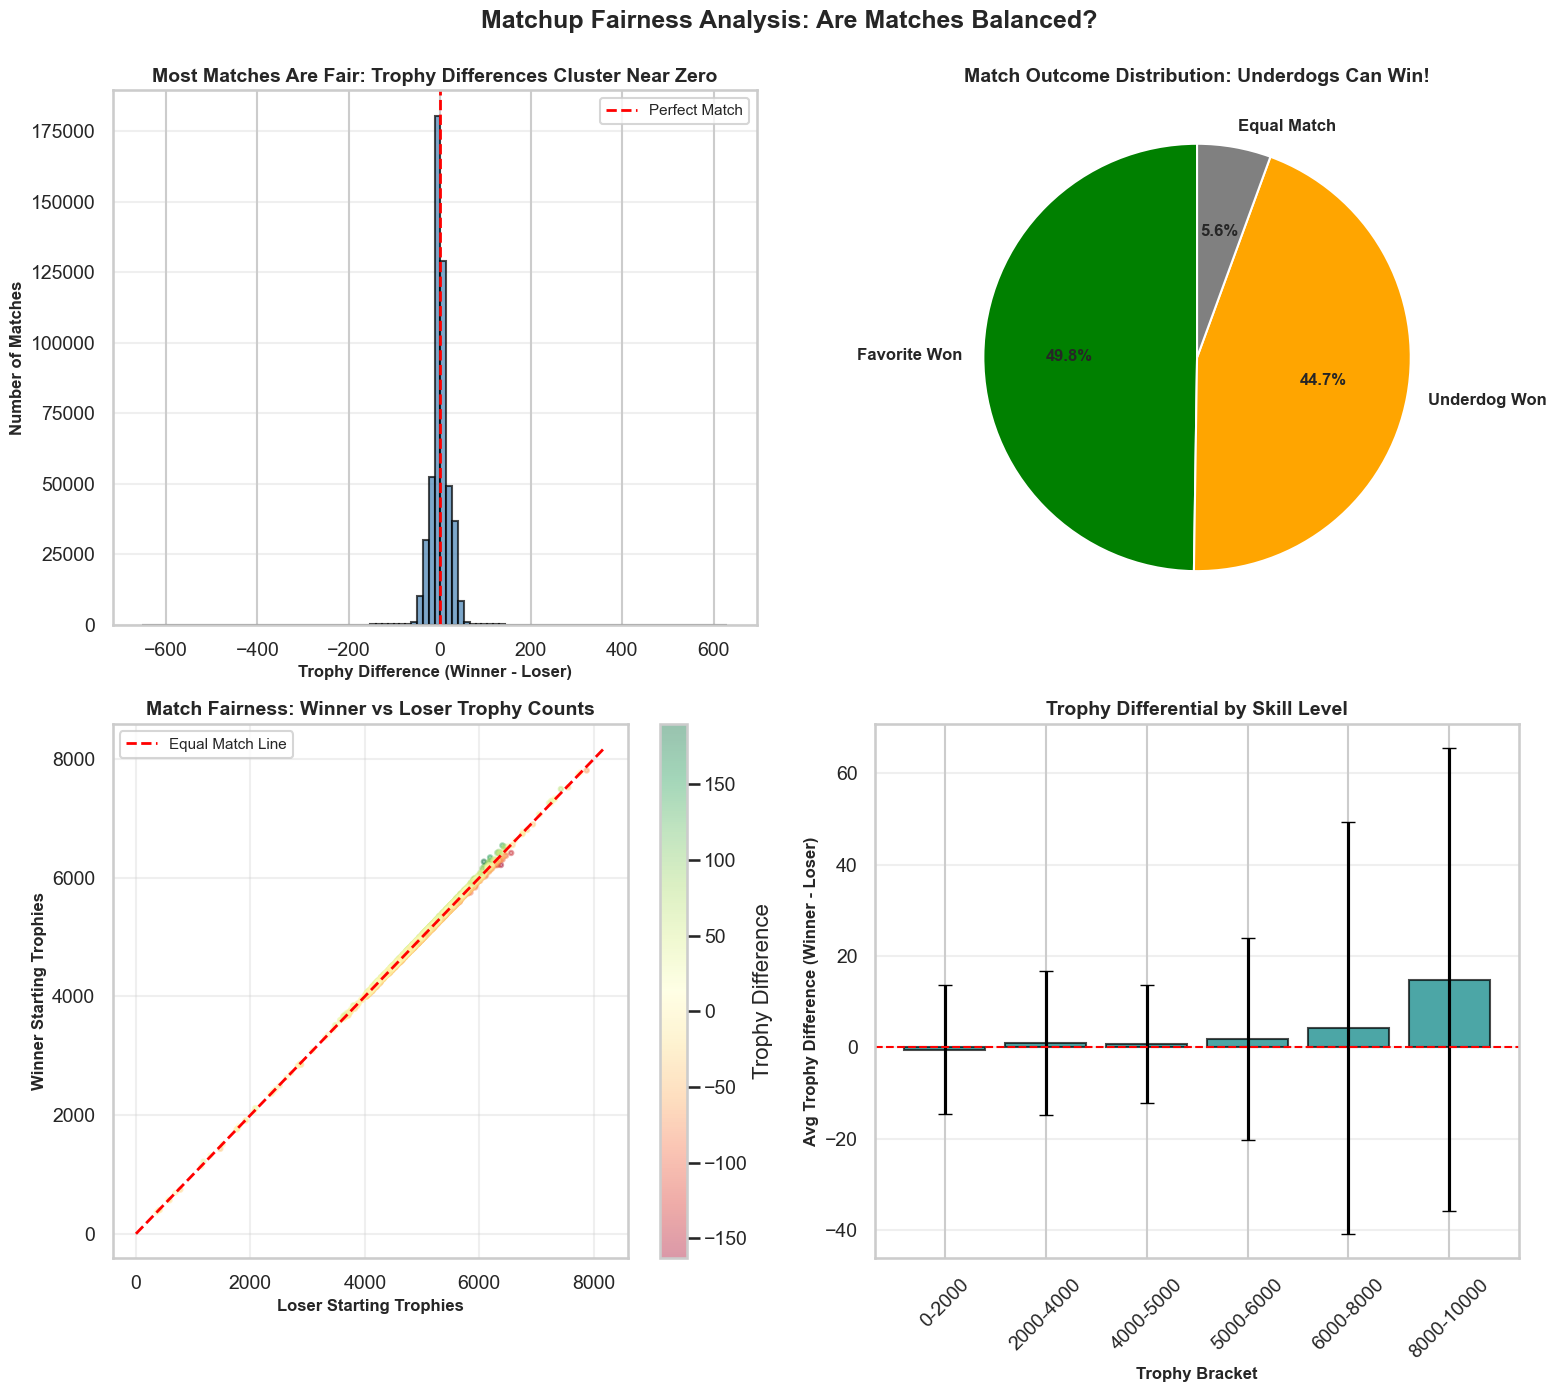

✓ Matchup fairness analysis complete

Analyzed 500,000 battles

Match type distribution:
  Favorite Won: 248,831 (49.8%)
  Underdog Won: 223,279 (44.7%)
  Equal Match: 27,890 (5.6%)

Trophy difference statistics:
  Mean: 1.2
  Median: 0.0
  Std Dev: 18.6

Underdogs win 223,279 times!


In [5]:
# Analyze matchup fairness: trophy differential between winner and loser
matchup_fairness_query = """
    SELECT 
        ("winner.startingTrophies" - "loser.startingTrophies") as trophy_diff,
        CASE 
            WHEN "winner.startingTrophies" > "loser.startingTrophies" THEN 'Favorite Won'
            WHEN "winner.startingTrophies" < "loser.startingTrophies" THEN 'Underdog Won'
            ELSE 'Equal Match'
        END as match_type,
        "winner.startingTrophies" as winner_trophies,
        "loser.startingTrophies" as loser_trophies
    FROM battles
    WHERE "winner.startingTrophies" IS NOT NULL 
      AND "loser.startingTrophies" IS NOT NULL
    LIMIT 500000
"""

matchup_data = query_to_df(con, matchup_fairness_query)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Trophy differential distribution
ax = axes[0, 0]
ax.hist(matchup_data['trophy_diff'], bins=100, color='steelblue', 
        edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Match')
ax.set_xlabel('Trophy Difference (Winner - Loser)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Matches', fontsize=12, fontweight='bold')
ax.set_title('Most Matches Are Fair: Trophy Differences Cluster Near Zero', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Match type distribution
ax = axes[0, 1]
match_type_counts = matchup_data['match_type'].value_counts()
colors_pie = ['green', 'orange', 'gray']
ax.pie(match_type_counts.values, labels=match_type_counts.index, autopct='%1.1f%%',
       colors=colors_pie, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Match Outcome Distribution: Underdogs Can Win!', 
             fontsize=14, fontweight='bold')

# Plot 3: Scatter plot of winner vs loser trophies
ax = axes[1, 0]
# Sample for visualization (too many points otherwise)
sample_scatter = matchup_data.sample(min(10000, len(matchup_data)), random_state=42)
scatter = ax.scatter(sample_scatter['loser_trophies'], sample_scatter['winner_trophies'], 
                     c=sample_scatter['trophy_diff'], cmap='RdYlGn', alpha=0.4, s=10)
ax.plot([0, matchup_data['loser_trophies'].max()], 
        [0, matchup_data['loser_trophies'].max()], 
        'r--', linewidth=2, label='Equal Match Line')
ax.set_xlabel('Loser Starting Trophies', fontsize=12, fontweight='bold')
ax.set_ylabel('Winner Starting Trophies', fontsize=12, fontweight='bold')
ax.set_title('Match Fairness: Winner vs Loser Trophy Counts', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Trophy Difference')

# Plot 4: Trophy difference by trophy bracket
ax = axes[1, 1]
trophy_brackets = [0, 2000, 4000, 5000, 6000, 8000, 10000]
matchup_data['trophy_bracket'] = pd.cut(matchup_data['winner_trophies'], 
                                         bins=trophy_brackets, 
                                         labels=[f'{trophy_brackets[i]}-{trophy_brackets[i+1]}' 
                                                for i in range(len(trophy_brackets)-1)])
bracket_stats = matchup_data.groupby('trophy_bracket')['trophy_diff'].agg(['mean', 'std'])
bracket_stats = bracket_stats.dropna()

x_pos = np.arange(len(bracket_stats))
ax.bar(x_pos, bracket_stats['mean'], yerr=bracket_stats['std'], 
       color='teal', alpha=0.7, edgecolor='black', capsize=5)
ax.set_xlabel('Trophy Bracket', fontsize=12, fontweight='bold')
ax.set_ylabel('Avg Trophy Difference (Winner - Loser)', fontsize=12, fontweight='bold')
ax.set_title('Trophy Differential by Skill Level', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(bracket_stats.index, rotation=45)
ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Matchup Fairness Analysis: Are Matches Balanced?', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
save_figure('fig_matchup_fairness.png')
plt.show()

print("✓ Matchup fairness analysis complete")
print(f"\nAnalyzed {len(matchup_data):,} battles")
print("\nMatch type distribution:")
for match_type, count in match_type_counts.items():
    pct = count / len(matchup_data) * 100
    print(f"  {match_type}: {count:,} ({pct:.1f}%)")
print(f"\nTrophy difference statistics:")
print(f"  Mean: {matchup_data['trophy_diff'].mean():.1f}")
print(f"  Median: {matchup_data['trophy_diff'].median():.1f}")
print(f"  Std Dev: {matchup_data['trophy_diff'].std():.1f}")
print(f"\nUnderdogs win {(matchup_data['match_type'] == 'Underdog Won').sum():,} times!")

## Key Insights

**Document progression patterns for presentation**